In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
dataset_path = "gdrive/My Drive/Colab Notebooks/DEEP LEARNING/deeplearning3/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten


Using TensorFlow backend.


In [0]:
series = loadmat(dataset_path + 'data.mat')
series = series['X']

In [0]:
n_observations = np.arange(series.shape[0]) 
variables = ["Wind speed","Wind direction", "Temperature", "Dew Point","Air Pressure"]
n_cities = series.shape[1]
n_variables = series.shape[2]

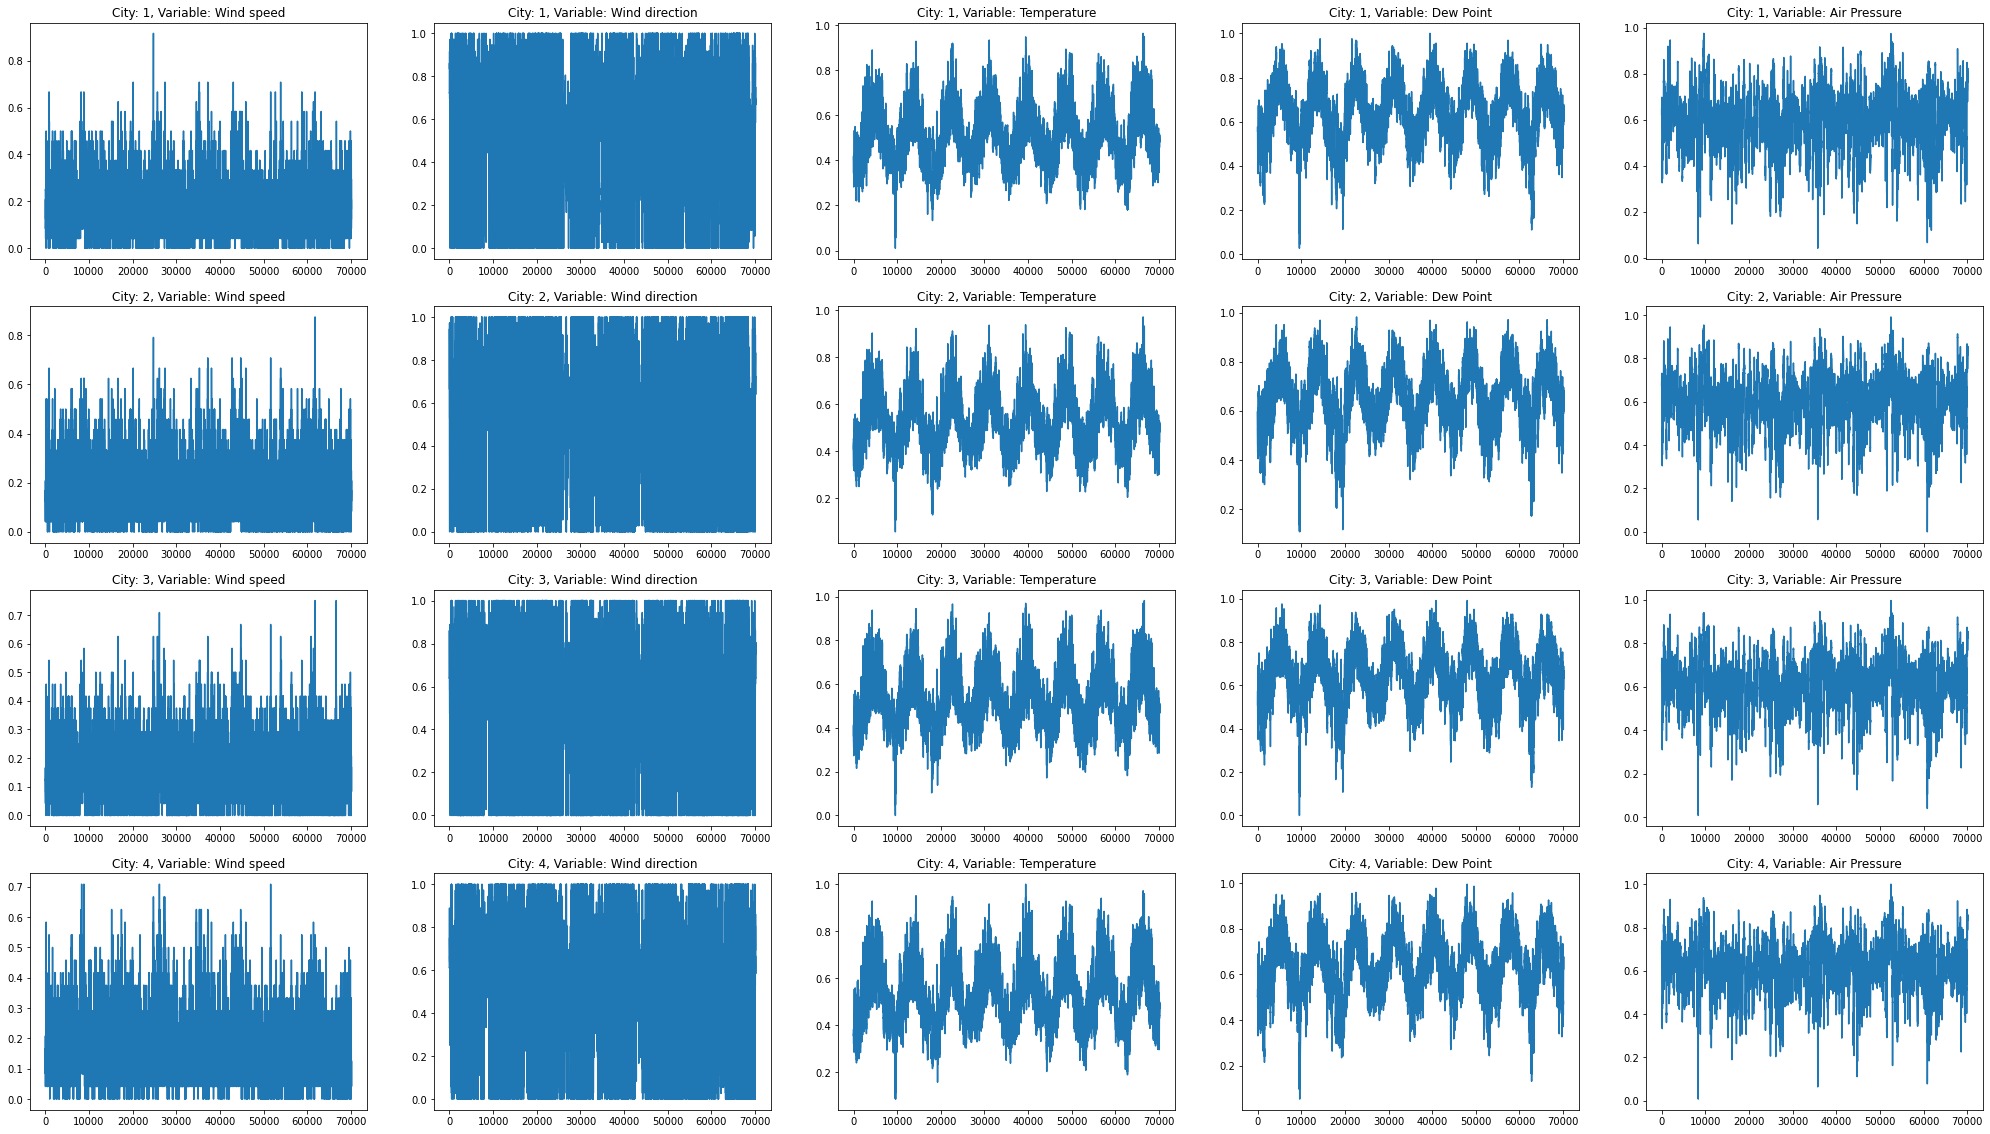

In [5]:
fig, axs = plt.subplots(n_cities, n_variables, figsize = (35,20))
for city in range(n_cities):
  for variable in range(n_variables):
    axs[city, variable].plot(n_observations, series[:, city, variable])
    axs[city, variable].set_title('City: ' + str(city + 1) + ", Variable: " + str(variables[variable]))  

In [0]:
test_series_size = 168
train_series = series[:-test_series_size,:,:]
test_series = series[-test_series_size:,:,:]

In [0]:
def create_dataset(data, time_steps):
  samples = data.shape[0] - time_steps
  channel_to_predict = 2
  city_to_predict = 3
  X = np.zeros((samples, time_steps, data.shape[1], data.shape[2]))
  y = np.zeros((samples))
  for i in range(samples):
    for j in range(time_steps):
      X[i, j, : , :] =  data[i + j, :, :]
    y[i] = data[i + j + 1, city_to_predict, channel_to_predict]
  return X, y 

In [0]:
time_step = 80
channel_to_predict = 2
city_to_predict = 3
X_train, y_train = create_dataset(series, time_step)

In [0]:
def CNN_model(X,y):
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=X_train[0].shape, data_format="channels_last"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(64, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(32, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(8, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(1, kernel_initializer= 'normal', activation='relu'))
  model.compile(optimizer='adam', loss='mse')
  model.fit(X, y, epochs=100, verbose=1, batch_size=32)
  return model

In [10]:
model = CNN_model(X_train,y_train)

Epoch 1/100
70048/70048 [==============================] - 17s 244us/step - loss: 0.0028
Epoch 2/100
70048/70048 [==============================] - 10s 141us/step - loss: 4.1916e-04
Epoch 3/100
70048/70048 [==============================] - 10s 142us/step - loss: 3.0319e-04
Epoch 4/100
70048/70048 [==============================] - 10s 140us/step - loss: 2.4464e-04
Epoch 5/100
70048/70048 [==============================] - 10s 146us/step - loss: 2.2704e-04
Epoch 6/100
70048/70048 [==============================] - 10s 144us/step - loss: 2.0873e-04
Epoch 7/100
70048/70048 [==============================] - 10s 143us/step - loss: 1.9436e-04
Epoch 8/100
70048/70048 [==============================] - 10s 143us/step - loss: 1.8989e-04
Epoch 9/100
70048/70048 [==============================] - 10s 145us/step - loss: 1.8748e-04
Epoch 10/100
70048/70048 [==============================] - 10s 149us/step - loss: 1.7907e-04
Epoch 11/100
70048/70048 [==============================] - 10s 144us/ste

In [11]:
import copy
copy_test_series = copy.deepcopy(test_series) 
series_input = train_series[-time_step:,:,:]
prediction = []
for i in range(test_series.shape[0]):
  y_pred = model.predict(series_input.reshape(1,series_input.shape[0], series_input.shape[1],series_input.shape[2]))
  prediction.append(y_pred)
  series_input = np.delete(series_input, obj=0, axis=0)
  copy_test_series[i,city_to_predict,channel_to_predict] = y_pred
  series_input = np.append(series_input, copy_test_series[i].reshape(1,copy_test_series.shape[1], copy_test_series.shape[2] ), axis=0)
prediction = np.array(prediction).reshape(test_series.shape[0],1)
real_temperature_values = test_series[:,city_to_predict,channel_to_predict]
mse = mean_squared_error(real_temperature_values, prediction)
print(mse)

0.000415837197645788


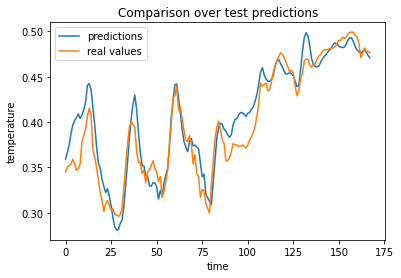

In [13]:
n_observations = np.arange(test_series.shape[0]) 
plt.plot(n_observations, prediction, label='predictions')
plt.plot(n_observations, real_temperature_values, label='real values')
plt.title("Comparison over test predictions")
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
plt.show()